In [3]:
%matplotlib inline
import gc
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from prg import prg
np.random.seed(7)

from keras.regularizers import l2
from keras.models import Sequential, load_model
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling2D, MaxPooling1D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM
from keras.optimizers import RMSprop
from keras.initializers import Zeros
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ProgbarLogger
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import to_categorical
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.preprocessing import StandardScaler

from retreive_data import unpack_gzip_generator

import keras.backend as K

In [4]:
#load the ATAC_STARR data
is_clinvar = True
x, y = (4, 500)

def retrieve_data(i):
    #Non-batch training
    alt_data = list()
    ref_data = list()
    common_alt_data = list()
    common_ref_data = list()

    if is_clinvar:
        print "unpacking common set", i
        common_alt_data = unpack_gzip_generator("../allele_specific_prediction/common_snps_altset" + str(i) + ".txt.gz")
        print "common alt done"
        common_ref_data = unpack_gzip_generator("../allele_specific_prediction/common_snps_refset" + str(i) + ".txt.gz")
        print "unpacking alt and ref"
        alt_data, _ = unpack_gzip("../allele_specific_prediction/clinvar_alts2.txt.gz")
        print "alt done"
        ref_data, _ = unpack_gzip("../allele_specific_prediction/clinvar_refs2.txt.gz")
        
        print "reshaping"
        common_alt_data = np.asarray(common_alt_data).reshape(np.array(common_alt_data).shape[0], x, y, 1)
        print common_alt_data.shape
        common_ref_data = np.asarray(common_ref_data).reshape(np.array(common_ref_data).shape[0], x, y, 1)
        print common_ref_data.shape
        alt_data = alt_data.reshape(alt_data.shape[0], x, y, 1)
        print alt_data.shape
        ref_data = ref_data.reshape(ref_data.shape[0], x, y, 1)
        print ref_data.shape
    else:
        for i in range(1, 23):
            print "using chromosome ", i
            x, y = unpack_gzip("../allele_specific_prediction/chr" + str(i) + "alt_binary.txt.gz")
            alt_data.extend(list(x))
            x, y = unpack_gzip("../allele_specific_prediction/chr" + str(i) + "ref_binary.txt.gz")
            ref_data.extend(list(x))
            
            
    return alt_data, ref_data, common_alt_data, common_ref_data

In [5]:
#determine best model from round-robin aurocs
data_version = "std5"

res_dict = np.load(data_version + "res.npy").item()

best_score = 0
best_chrm = None
for chrm in res_dict.keys():
    score = roc_auc_score(res_dict[chrm][0], res_dict[chrm][1])
    if best_score < score:
        best_chrm = chrm
        best_score = score

print best_chrm, best_score
    
best_model = "best_model_" + data_version + best_chrm[3:] + ".hdf5"
print "using " + best_model

chr22 0.804359262117
using best_model_std522.hdf5


In [6]:
def retrieve_predictions(alt_data, ref_data, common_alt_data, common_ref_data): #feed in generators please
    model = load_model(best_model)
    print model.summary()
    print "predicting on alt"
    common_alt_results = model.predict_generator(common_alt_data, 3800000)
    print "predicting on ref"
    common_ref_results = model.predict_generator(common_ref_data, 3800000)
    print "predicting on alt"
    alt_results = model.predict(alt_data)
    print "predicting on ref"
    ref_results = model.predict(ref_data)
    
    return alt_results, ref_results, common_alt_results, common_ref_results

In [7]:
# print alt_results
for i in range(0, 10):
    alt_data, ref_data, common_alt_data, common_ref_data = retrieve_data(i)
    alt_results, ref_results, common_alt_results, common_ref_results = retrieve_predictions(alt_data, ref_data, common_alt_data, common_ref_data)

    common_diff = np.abs(common_alt_results - common_ref_results).flatten()
    mx = np.max(common_diff)
    diff = np.abs(alt_results - ref_results).flatten()
    plt.figure(dpi=150)
    p = plt.hist(common_diff, bins = 50, normed = True, stacked = True, label = "Common Variants", range = (0, mx))
    m = plt.hist(diff, bins = 50, alpha = .5, normed = True, stacked = True, label = "Clinical Variants", range = (0, mx))
    plt.ylabel("Normalized Counts")
    plt.xlabel("Absolute alt-ref")
    plt.legend()
    plt.title("Non-coding Clinical Variants vs. Common Variant in silico mutagenesis (abs(alt-ref))")
    savefig("altrefonset" + str(i) + ".pdf")
    #plt.show()


unpacking common set 0
common alt done
unpacking alt and ref
alt done
reshaping


IndexError: tuple index out of range

In [33]:
p

(array([  5.99230669e+01,   4.89360671e+01,   3.84633551e+01,
          2.95610580e+01,   2.25328942e+01,   1.71938774e+01,
          1.31720674e+01,   9.97613550e+00,   7.55950720e+00,
          5.70308535e+00,   4.28879365e+00,   3.32581582e+00,
          2.61604605e+00,   1.92070783e+00,   1.51662449e+00,
          1.10991723e+00,   8.77700506e-01,   6.92058321e-01,
          5.05104178e-01,   3.86371897e-01,   3.26021787e-01,
          2.57799924e-01,   2.13849301e-01,   1.63338883e-01,
          1.34475788e-01,   8.65892876e-02,   8.72452670e-02,
          8.19974314e-02,   5.51022739e-02,   5.24783561e-02,
          3.01750548e-02,   2.42712397e-02,   2.36152603e-02,
          2.36152603e-02,   1.24636096e-02,   1.37755685e-02,
          8.52773287e-03,   7.21577397e-03,   8.52773287e-03,
          5.90381506e-03,   2.62391781e-03,   3.27989726e-03,
          2.62391781e-03,   6.55979451e-04,   0.00000000e+00,
          0.00000000e+00,   6.55979451e-04,   0.00000000e+00,
        

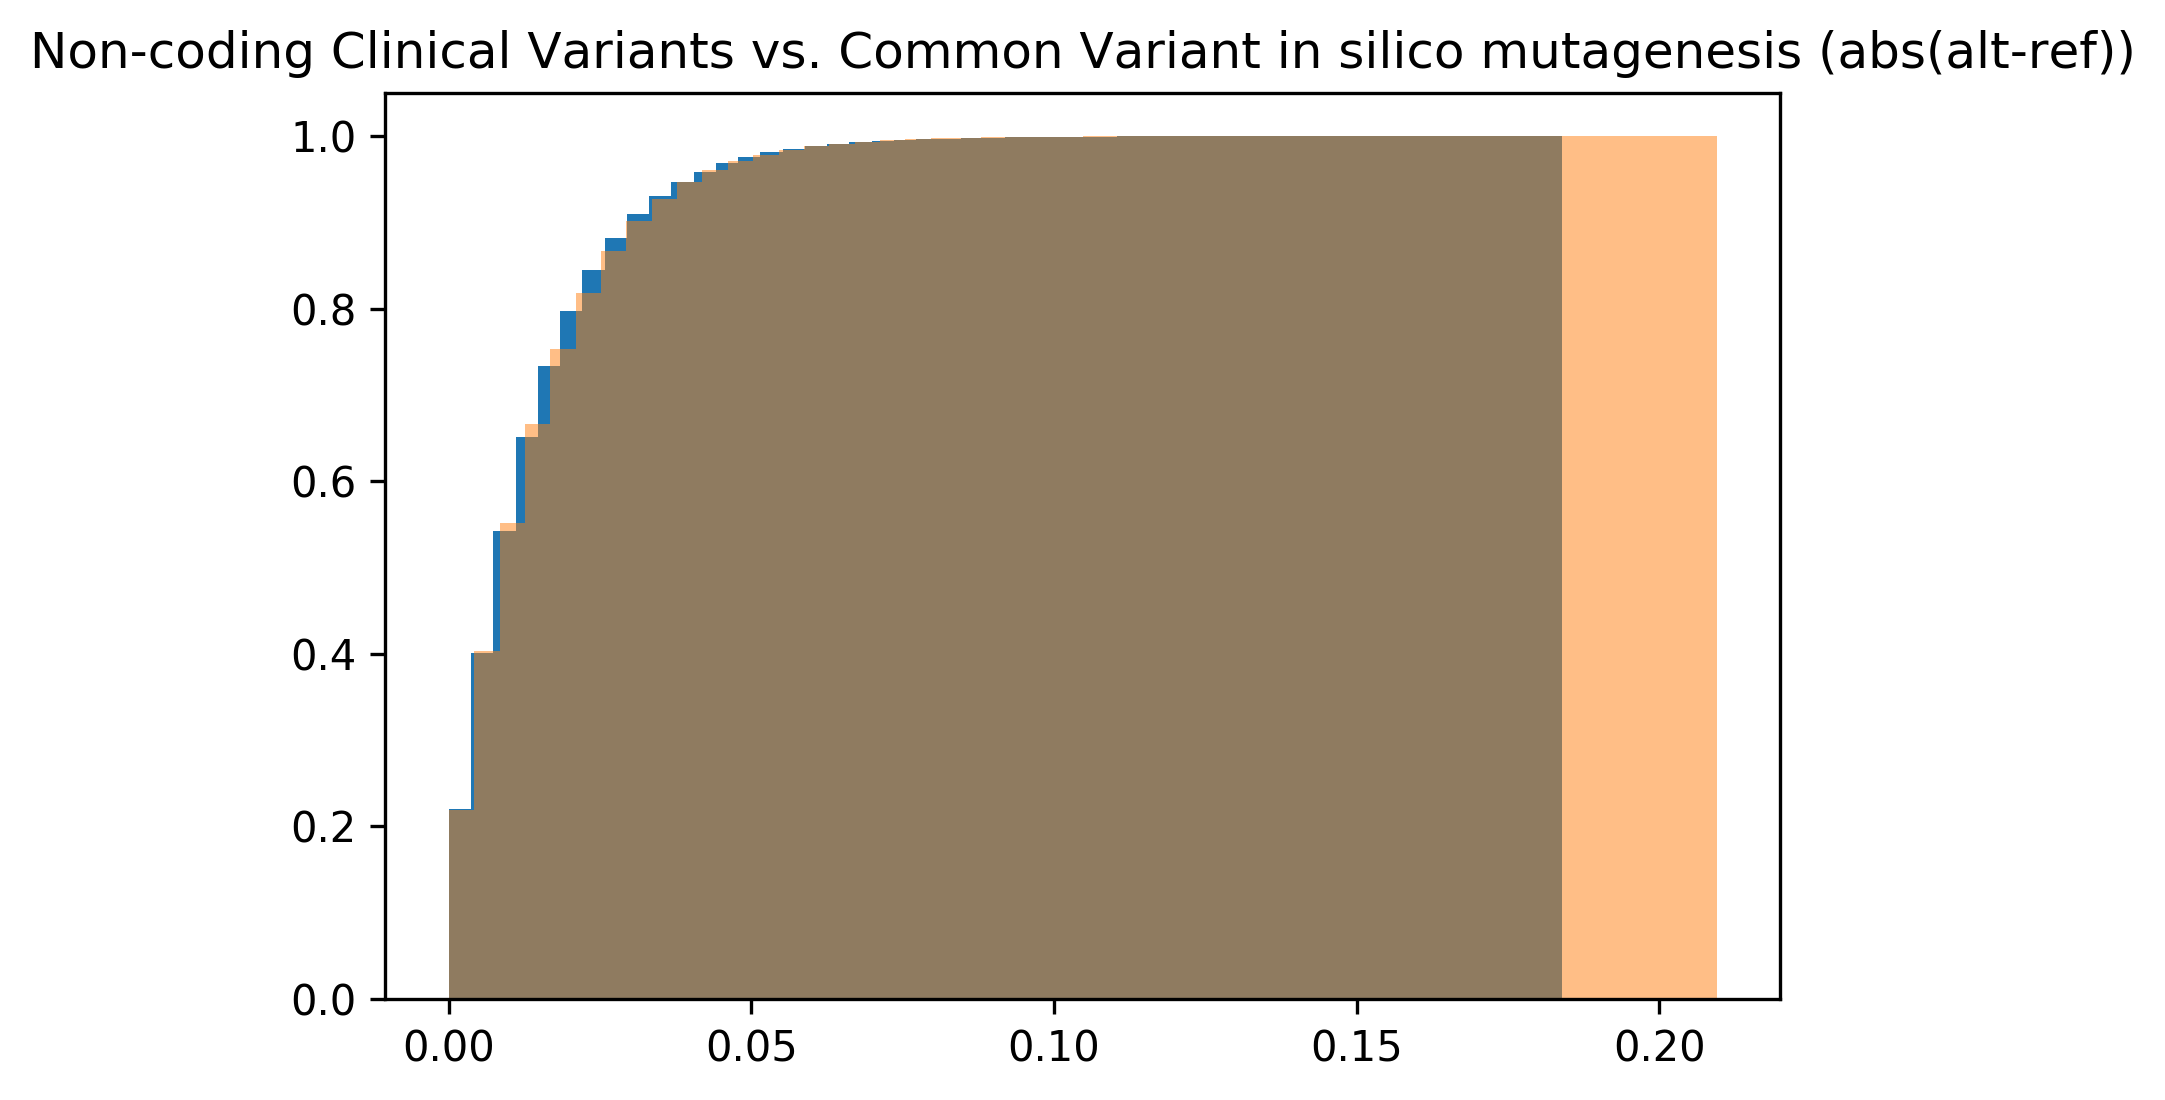

In [41]:
# print alt_results
ratio = 251246./414477.
common_diff = np.abs(common_alt_results - common_ref_results).flatten()
diff = np.abs(alt_results - ref_results).flatten()
plt.figure(dpi=300)
plt.hist(common_diff, bins = 50, normed = True, cumulative = True)
plt.hist(diff, bins = 50, alpha = .5, normed = True, cumulative = True)
plt.ylabel("")
plt.title("Non-coding Clinical Variants vs. Common Variant in silico mutagenesis (abs(alt-ref))")
plt.show()


In [31]:
?plt.hist

In [27]:
#two-sample ks test, t test, get p-values
from scipy.stats import ks_2samp, ttest_ind, mannwhitneyu
print "K-S statistic: ", ks_2samp(common_diff, diff)
print "t-test: ", ttest_ind(common_diff, diff)
print "Mann-Whitney u-test", mannwhitneyu(common_diff, diff)

K-S statistic:  Ks_2sampResult(statistic=0.04110420512074936, pvalue=4.0102125435984978e-230)
t-test:  Ttest_indResult(statistic=-28.070875368643051, pvalue=2.8066364779384366e-173)
Mann-Whitney u-test MannwhitneyuResult(statistic=49322696124.0, pvalue=6.1753893421816319e-286)
